Synthetic ice inversion using adjoints
=======================================================
In the previous tutorials we have seen how to run Glacial Isostatic Adjustment (GIA)
models forward in time. Two of the key ingredients are an ice loading history and
a viscosity structure of the mantle. However, like many problems in Earth Sciences,
these inputs are not known. We need to infer these unknown inputs based on any
geological and geophysical observations that we can get our hands on! In the GIA
problem this is often in the form of paleo relative sea level markers and present
day geodetic observations.

In this tutorial, we will demonstrate how to perform an inversion to recover the
ice thickness distribution of an idealised GIA simulation using G-ADOPT. We make
the important assumption that we know the viscosity structure of the mantle.
In reality, this is not the case, but it will simplify things for this first example!

The tutorial involves a *twin experiment*, where we assess the performance of the
inversion scheme by inverting the ice thickness distribution to match a synthetic
reference simulation, known as the "*Reference Twin*". To create this reference
twin, we run a forward GIA simulation and record all relevant fields at each time
step. In our case, this will be the displacement and velocity recorded at the
surface of the Earth. We will use these outputs of the reference twin as the
"observations" for our inversion.

[The reference case](../2d_cylindrical_lvv) for this tutorial is the 2D
cylindrical tutorial with lateral viscosity variations we saw previously.
We have run the model forwards in time and stored the model output as a checkpoint
file on our servers. To download the reference benchmark checkpoint file if it
doesn't already exist, execute the following command:

In [1]:
![ ! -f forward-2d-cylindrical-disp-vel.h5 ] && wget https://data.gadopt.org/demos/forward-2d-cylindrical-disp-vel.h5

Gradient-based optimisation and the Adjoint method
--------------------------------------------------
So the next obvious question is: how do we actually find the initial ice thickness
distribution? A first approach could be just to guess a lot of different ice
histories...! We could input these to our GIA code and then compare the misfit
between the outputs of our model with the observations.

As you can imagine, this can quickly become expensive depending on the cost of the
forward model! Also, for the simplest grid based discretisations of ice thickness
every time we refine the grid there will be more combinations of parameters to
choose! Generally, with 3D finite element models these kind of direct search methods
are not practical.

The trick up our sleeve is that *G-ADOPT* (thanks to *Firedrake* and *Pyadjoint*),
is able to calculate the gradient of an output functional from the forward model,
for example a misfit between model predictions and observations, with respect to
input parameters via an automatically generated *Adjoint* model. Using this
technique, it is possible to compute the gradient of a functional in a cost
independent of the number of parameters! In practice, the cost associated with
generating the adjoint model is usually a fraction of the (nonlinear) forward model.
If you are interested to learn more about Adjoint models, please see this nice
[introduction](https://www.dolfin-adjoint.org/en/latest/documentation/maths/)
from the Dolfin-Adjoint website.

Once we have the adjoint model, we can use the gradient information to speed up our
inversion by finding efficient search directions to adjust the unknown input
parameters. This forms the basis of an iterative procedure, where we find the
gradient of the misfit w.r.t the model inputs, update the model inputs to
(hopefully!) decrease the misfit and then find the new gradient and so on...
(N.b. the optimisation algorithm we use later on actually also approximates the
Hessian, i.e. second order derivatives, to make the inversion process more efficient.)

The rest of this tutorial will focus on how to set up an adjoint problem. The key
steps are summarised as follows:
1. Defining an objective function.
2. Verifying the accuracy of the gradients using a Taylor test.
3. Setting up and solving a gradient-based minimisation problem for a synthetic ice
load.

This example
-------------
Let's get started!
The first step is to import the gadopt module, which
provides access to Firedrake and associated functionality.

In [2]:
from gadopt import *

The novelty of using the overloading approach provided by pyadjoint is that it requires
minimal changes to our script to enable the inverse capabilities of G-ADOPT.
To turn on the adjoint, one simply imports the inverse module to
enable all taping functionality from pyadjoint. Doing so will turn Firedrake's objects
to overloaded types, in a way that any UFL operation will be annotated and added to
the tape, unless otherwise specified.

In [3]:
from gadopt.inverse import *

We also import some G-ADOPT utilities for later use.

In [4]:
from gadopt.utility import (
    CombinedSurfaceMeasure,
    initialise_background_field
)
from gadopt.demos.glacial_isostatic_adjustment.utils import (
    ice_sheet_disc,
    setup_heterogenous_viscosity
)

In [5]:
from gadopt_demo_utils.gia_demo_utils import (
   plot_adj_ring,
   plot_displacement,
   plot_ice_ring,
   plot_viscosity,
)

We first ensure that the tape is cleared of any previous operations, using the
following code

In [6]:
tape = get_working_tape()
tape.clear_tape()

To verify the tape is empty, we can print all blocks:

In [7]:
print(tape.get_blocks())

[]


We then begin annotation.

In [8]:
continue_annotation()

True

In this tutorial we are going to load the mesh from the checkpoint created by the
[the forward case](../2d_cylindrical_lvv). This makes it
easier to load the synthetic data from the previous tutorial for our 'twin'
experiment.

In [9]:
checkpoint_file = "forward-2d-cylindrical-disp-vel.h5"
with CheckpointFile(checkpoint_file, 'r') as afile:
    mesh = afile.load_mesh(name='surface_mesh_extruded')
bottom_id, top_id = "bottom", "top"
mesh.cartesian = False
boundary = get_boundary_ids(mesh)

We next set up the function spaces, and specify functions to hold our solutions.

In [10]:
V = VectorFunctionSpace(mesh, "CG", 2)  # Displacement function space
S = TensorFunctionSpace(mesh, "DQ", 1)  # Stress tensor function space
DG0 = FunctionSpace(mesh, "DQ", 0)  # Density and shear modulus function space
DG1 = FunctionSpace(mesh, "DQ", 1)  # Viscosity function space
P1 = FunctionSpace(mesh, "CG", 1)  # Ice thickness function space
R = FunctionSpace(mesh, "R", 0)  # Real function space (for constants)

u = Function(V, name='displacement')
m = Function(S, name="internal variable")

Let's set up the background profiles for the material properties with the same values
as before, as well as the laterally varying viscosity field.

In [11]:
X = SpatialCoordinate(mesh)

# Layer properties from Spada et al. (2011)
radius_values = [6371e3, 6301e3, 5951e3, 5701e3, 3480e3]  # radius values in m
domain_depth = radius_values[0]-radius_values[-1]
radius_values_nondim = np.array(radius_values)/domain_depth

density_values = [3037, 3438, 3871, 4978]  # Density in [kg/m^3]
shear_modulus_values = [0.50605e11, 0.70363e11, 1.05490e11, 2.28340e11]  # Shear modulus in [Pa]
bulk_shear_ratio = 1.94  # ratio of bulk modulus to shear modulus
viscosity_values = [1e25, 1e21, 1e21, 2e21]  # Viscosity in [Pa s]

density_scale = 4500
shear_modulus_scale = 1e11
viscosity_scale = 1e21
characteristic_maxwell_time = viscosity_scale / shear_modulus_scale

density_values_nondim = np.array(density_values)/density_scale
shear_modulus_values_nondim = np.array(shear_modulus_values)/shear_modulus_scale
viscosity_values_nondim = np.array(viscosity_values)/viscosity_scale

density = Function(DG0, name="density")
initialise_background_field(
    density, density_values_nondim, X, radius_values_nondim)

shear_modulus = Function(DG0, name="shear modulus")
initialise_background_field(
    shear_modulus, shear_modulus_values_nondim, X, radius_values_nondim)

bulk_modulus = Function(DG0, name="bulk modulus")
initialise_background_field(
    bulk_modulus, shear_modulus_values_nondim, X, radius_values_nondim)

background_viscosity = Function(DG1, name="background viscosity")
initialise_background_field(
    background_viscosity, viscosity_values_nondim, X, radius_values_nondim)

viscosity = setup_heterogenous_viscosity(X, background_viscosity)

Defining the Control
---------------------

The next key step is to define our control, i.e. the field or parameter
that we are inverting for. In our case, this is the ice thickness.
For this tutorial we will start with an ice thickness of
zero everywhere, but our target ice load will be the same two synthetic ice sheets in
the previous demo.

Since the ice thickness is only defined at the surface of the Earth we define the
control on a surface mesh and then interpolate the control ice thickness to the
2D computational domain to ensure that the interior sensitivity is always
zero. Let's setup the ice thickness control field now.

In [12]:
# Construct a surface mesh
rmax = radius_values_nondim[0]
ncells = 180
surface_mesh = CircleManifoldMesh(ncells, radius=rmax, degree=1, name='surface_mesh')

# Define control on surface mesh
P1_surf = FunctionSpace(surface_mesh, "CG", 1)  # Function space on surface mesh for control
ice_thickness_control = Function(P1_surf, name="Ice thickness (control)")  # What we optimise
control = Control(ice_thickness_control, riesz_map="L2")

In the cell above, when we initialised the control field, we also specified the option
`riesz_map=L2`. This ensures we use the $L_2$ derivative for optimisation, as opposed
to the more traditional Euclidean $l_2$ derivative that is defined with respect
to the control vector’s discrete degrees of freedom. The L2 formulation is
more appropriate because it properly accounts for variations in mesh cell size.
Specifically, the optimisation is driven by the gradients
$\left[\frac{\partial J}{\partial h_{\text{load}}}\right]_{L_2(\partial\Omega_{\text{top}})}$
such that sensitivity of the objective function to perturbations $\delta h_{\text{load}}$
in thickness is given by

\begin{equation}
  \delta J = \int_{\partial\Omega_{\text{top}}} \left[\frac{\partial J}{\partial h_{\text{load}}}\right]_{L_2(\partial\Omega_{\text{top}})}
  \delta h_{\text{load}}~ds
\end{equation}

We now interpolate our control ice thickness field (defined on the surface mesh)
into a Firedrake Function defined onto the full 2D computational mesh, so that
we can apply this as a load through the boundary conditions. We specify the option
`allow_missing_dofs` to let Firedrake know that our target mesh extends outside
the source mesh.

In [13]:
# Interpolate control to computational domain (full 2D cylindrical mesh)
ice_thickness_full = Function(P1, name="Ice thickness (full mesh)")
ice_thickness_full.interpolate(ice_thickness_control, allow_missing_dofs=True)

Coefficient(WithGeometry(FunctionSpace(<firedrake.mesh.ExtrudedMeshTopology object at 0x7f0d0fba6c90>, TensorProductElement(FiniteElement('Lagrange', interval, 1), FiniteElement('Lagrange', interval, 1), cell=TensorProductCell(interval, interval)), name=None), Mesh(VectorElement(TensorProductElement(FiniteElement('Lagrange', interval, 2), FiniteElement('Lagrange', interval, 1), cell=TensorProductCell(interval, interval)), dim=2), 1)), 82)

We next set up the relevant parameters for the ice load and set up a target
ice thickness field for comparison with our final inversion.

In [14]:
# Initialise ice loading
rho_ice = 931 / density_scale
g = 9.815
B_mu = Constant(density_scale * domain_depth * g / shear_modulus_scale)
log("Ratio of buoyancy/shear = rho g D / mu = ", float(B_mu))
Hice1 = 1000 / domain_depth
Hice2 = 2000 / domain_depth

# Setup up target ice thickness
disc_centre1 = (2*pi/360) * 25  # Centre of disc 1 in radians
disc_centre2 = pi  # Centre of disc 2 in radians
disc_halfwidth1 = (2*pi/360) * 10  # Disc 1 half width in radians
disc_halfwidth2 = (2*pi/360) * 20  # Disc 2 half width in radians
disc1 = ice_sheet_disc(X, disc_centre1, disc_halfwidth1)
disc2 = ice_sheet_disc(X, disc_centre2, disc_halfwidth2)
ice_thickness_target = Function(P1, name="Ice thickness (target)")
ice_thickness_target.interpolate(Hice1 * disc1 + Hice2*disc2)

Ratio of buoyancy/shear = rho g D / mu =  1.276882425


Coefficient(WithGeometry(FunctionSpace(<firedrake.mesh.ExtrudedMeshTopology object at 0x7f0d0fba6c90>, TensorProductElement(FiniteElement('Lagrange', interval, 1), FiniteElement('Lagrange', interval, 1), cell=TensorProductCell(interval, interval)), name=None), Mesh(VectorElement(TensorProductElement(FiniteElement('Lagrange', interval, 2), FiniteElement('Lagrange', interval, 1), cell=TensorProductCell(interval, interval)), dim=2), 1)), 121)

Finally we set up the ice load using the `ice_thickness_full` field (defined on
the full mesh) that will force our simulation. Generally, it is a good idea to rescale
the unknown control parameters, because optimisation algorithms find it harder to
minimise a misfit if the control varies over many orders of mangitude. Here we have
used `Hscale` to normalise the magnitude of the control, so that we expect the control
ice thickness to vary between 0 and 2.

In [15]:
Hscale = 1000 / domain_depth
ice_load = B_mu * rho_ice * Hscale * ice_thickness_full

Let's visualise the ice thickness using pyvista, by plotting a ring outside our
synthetic Earth.

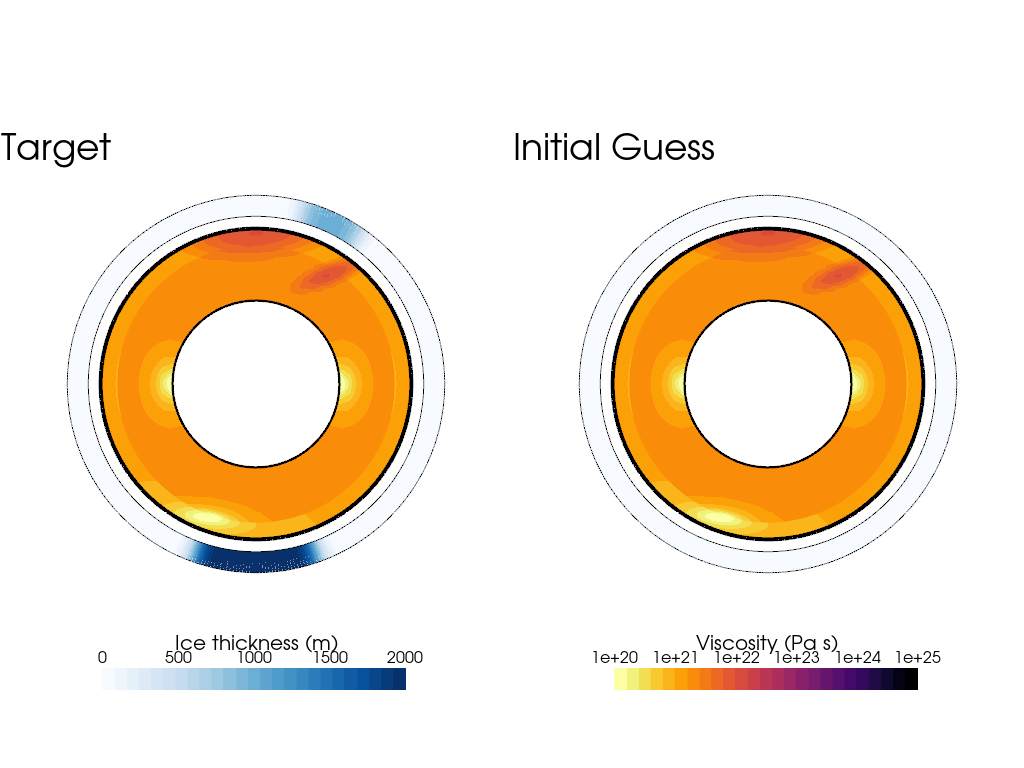

In [16]:
import pyvista as pv
import matplotlib.pyplot as plt

plot_kwargs = {'scalar_bar_vertical': False,
               'scalar_bar_x': 0.2,
               'scalar_bar_y':0.1}

text_pos = (1,600)

updated_ice_file = VTKFile('ice.pvd')
updated_ice_file.write(ice_thickness_full, ice_thickness_target)

# Create a plotter object
plotter = pv.Plotter(shape=(1, 2), border=False, notebook=True, off_screen=False)

visc_file = VTKFile('viscosity.pvd').write(viscosity)  # write out viscosity

plotter.subplot(0, 0)
plot_ice_ring(plotter, scalar='Ice thickness (target)', **plot_kwargs)
plot_viscosity(plotter,show_scalar_bar=False)
plotter.add_text("Target", position=text_pos)
plotter.camera_position = 'xy'

plotter.subplot(0, 1)
plot_ice_ring(plotter, scalar='Ice thickness (full mesh)')
plot_viscosity(plotter, **plot_kwargs)
plotter.add_text("Initial Guess", position=text_pos)
plotter.camera_position = 'xy'

plotter.show(jupyter_backend="static", interactive=False)
plotter.close()

Let's choose a timestep of 250 years as before.

In [17]:
# Timestepping parameters
Tstart = 0
year_in_seconds = 3600*24*365.25
time = Function(R).assign(Tstart * year_in_seconds)

dt_years = 250
dt = Constant(dt_years * year_in_seconds/characteristic_maxwell_time)
Tend_years = 10e3
Tend = Constant(Tend_years * year_in_seconds/characteristic_maxwell_time)
dt_out_years = 1e3
dt_out = Constant(dt_out_years * year_in_seconds/characteristic_maxwell_time)

max_timesteps = round((Tend - Tstart * year_in_seconds/characteristic_maxwell_time) / dt)

output_frequency = round(dt_out / dt)

We also need to specify boundary conditions, a G-ADOPT approximation, nullspaces and
finally the Stokes solver.

In [18]:
stokes_bcs = {boundary.top: {'free_surface': {'normal_stress': ice_load}},
              boundary.bottom: {'un': 0}
              }

approximation = MaxwellApproximation(
    bulk_modulus=bulk_modulus,
    density=density,
    shear_modulus=shear_modulus,
    viscosity=viscosity,
    B_mu=B_mu,
    bulk_shear_ratio=bulk_shear_ratio)

iterative_parameters = {"mat_type": "matfree",
                        "snes_type": "ksponly",
                        "ksp_type": "gmres",
                        "ksp_rtol": 1e-5,
                        "pc_type": "python",
                        "pc_python_type": "firedrake.AssembledPC",
                        "assembled_pc_type": "gamg",
                        "assembled_mg_levels_pc_type": "sor",
                        "assembled_pc_gamg_threshold": 0.01,
                        "assembled_pc_gamg_square_graph": 100,
                        "assembled_pc_gamg_coarse_eq_limit": 1000,
                        "assembled_pc_gamg_mis_k_minimum_degree_ordering": True,
                        }

nullspace = rigid_body_modes(V, rotational=True)
near_nullspace = rigid_body_modes(V, rotational=True, translations=[0, 1])

stokes_solver = InternalVariableSolver(
    u,
    approximation,
    dt=dt,
    internal_variables=m,
    bcs=stokes_bcs,
    solver_parameters=iterative_parameters,
    nullspace=nullspace,
    transpose_nullspace=nullspace,
    near_nullspace=near_nullspace
)

We next set up our output in VTK format. This format can be read by programs like
pyvista and Paraview.

In [19]:
# Create a velocity function for plotting
velocity = Function(V, name="velocity")
disp_old = Function(V, name="old_disp")
# Create output file
output_file = VTKFile("output.pvd")
output_file.write(u, m, velocity)

plog = ParameterLog("params.log", mesh)
plog.log_str(
    "timestep time dt u_rms u_rms_surf uv_min"
)

checkpoint_filename = "viscoelastic_loading-chk.h5"

gd = GeodynamicalDiagnostics(u, bottom_id=boundary.bottom, top_id=boundary.top)

Now is a good time to setup a helper function for defining the time integrated misfit
that we need later as part of our overall objective function. This is going to be
called at each timestep of the forward run to calculate the difference between the
displacement and velocity at the surface compared to our reference forward simulation.

In [20]:
# Overload surface integral measure for G-ADOPT's extruded meshes.
ds = CombinedSurfaceMeasure(mesh, degree=6)


def integrated_time_misfit(timestep, velocity_misfit, displacement_misfit):
    with CheckpointFile(checkpoint_file, 'r') as afile:
        target_displacement = afile.load_function(mesh, name="displacement", idx=timestep)
        target_velocity = afile.load_function(mesh, name="velocity", idx=timestep)
    circumference = 2 * pi * radius_values_nondim[0]
    velocity_error = velocity - target_velocity
    velocity_scale = 1e-5
    velocity_misfit += assemble(dot(velocity_error, velocity_error) / (circumference * velocity_scale**2) * ds(boundary.top))

    displacement_error = u - target_displacement
    displacement_scale = 1e-4
    displacement_misfit += assemble(dot(displacement_error, displacement_error) / (circumference * displacement_scale**2) * ds(boundary.top))
    return velocity_misfit, displacement_misfit

Now let's run the simulation! This is the same as the previous tutorial except we are calculating the surface
misfit between our current simulation and the reference run at each timestep.

In [21]:
velocity_misfit = 0
displacement_misfit = 0

for timestep in range(1, max_timesteps+1):

    time.assign(time+dt)
    stokes_solver.solve()

    velocity.interpolate((u - disp_old)/dt)
    disp_old.assign(u)

    velocity_misfit, displacement_misfit = integrated_time_misfit(timestep, velocity_misfit, displacement_misfit)

    # Log diagnostics:
    plog.log_str(f"{timestep} {time} {float(dt)} {gd.u_rms()} "
                 f"{gd.u_rms_top()} {gd.ux_max(boundary.top)} "
                 f"{gd.uv_min(boundary.top)}"
                 )

    if timestep % output_frequency == 0:
        log("timestep", timestep)

        output_file.write(u, m, velocity)

        with CheckpointFile(checkpoint_filename, "w") as checkpoint:
            checkpoint.save_function(u, name="displacement")
            checkpoint.save_function(m, name="internal variable")

timestep 4


timestep 8


timestep 12


timestep 16


timestep 20


timestep 24


timestep 28


timestep 32


timestep 36


timestep 40


As we can see from the plot below there is no displacement at the final time given there is no ice load!

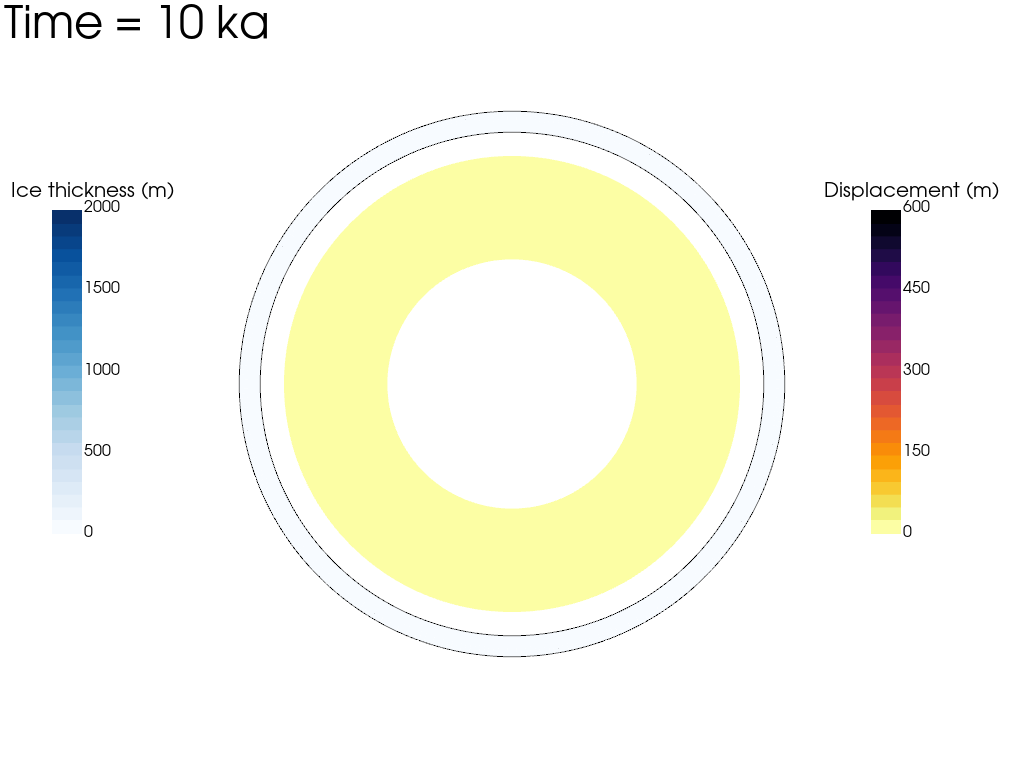

In [22]:
# Create a plotter object
plotter = pv.Plotter(shape=(1, 1), border=False, notebook=True, off_screen=False)

# Plot displacement

disp_scalar_bar_args={
        "title": 'Displacement (m)',
        "position_x": 0.85,
        "position_y": 0.3,
        "vertical": True,
        "title_font_size": 20,
        "label_font_size": 16,
        "fmt": "%.0f",
        "font_family": "arial",
    }
plot_displacement(plotter, disp='displacement', vel='velocity') #, scalar_bar_args=disp_scalar_bar_args)

plot_ice_ring(plotter, scalar='Ice thickness (full mesh)')

plotter.camera_position = 'xy'
plotter.add_text("Time = 10 ka")
plotter.show(jupyter_backend="static", interactive=False)
plotter.close()

The inverse problem
------------------------------

Now we can define our overall objective function that we want to minimise.
This includes the time integrated displacement and velocity misfit at the
surface as we discussed above.

In [23]:
J = (displacement_misfit + velocity_misfit) / max_timesteps
log("J = ", J)

J =  0.7463753988749042


Let's also pause annotation as we are now done with the forward terms.

In [24]:
pause_annotation()

Let's setup some call backs to help us keep track of the inversion.

In [25]:
updated_ice_thickness = Function(ice_thickness_full, name="Ice thickness (updated)")
updated_ice_thickness_file = VTKFile("updated_ice_thickness.pvd")
updated_displacement = Function(V, name="Displacement (updated)")
updated_velocity = Function(V, name="Velocity (velocity)")
updated_out_file = VTKFile("updated_out.pvd")

with CheckpointFile(checkpoint_file, 'r') as afile:
    final_target_displacement = afile.load_function(mesh, name="displacement", idx=max_timesteps)
    final_target_velocity = afile.load_function(mesh, name="velocity", idx=max_timesteps)

functional_values = []


def eval_cb(J, m):
    if functional_values:
        functional_values.append(min(J, min(functional_values)))
    else:
        functional_values.append(J)

    # Define the component terms of the overall objective functional
    log("displacement misfit", displacement_misfit.block_variable.checkpoint / max_timesteps)
    log("velocity misfit", velocity_misfit.block_variable.checkpoint / max_timesteps)

    # Write out values of control and final forward model results
    updated_ice_thickness.assign(ice_thickness_full.block_variable.checkpoint)
    updated_ice_thickness_file.write(updated_ice_thickness)
    updated_displacement.interpolate(u.block_variable.checkpoint)
    updated_velocity.interpolate(velocity.block_variable.checkpoint)
    updated_out_file.write(
        updated_displacement,
        final_target_displacement,
        updated_velocity,
        final_target_velocity)

Define the Reduced Functional
-----------------------------
The next important step is to define the reduced functional. This is pyadjoint's way of
associating our objective function with the control variable that we are trying to
optimise. It does this without explicitly depending on all intermediary
state variables, hence the name "reduced".

To define the reduced functional, we provide the class with an objective (which is an
overloaded UFL object) and the control. We can also pass our call back function which
will be called every time the functional is evaluated.

In [26]:
reduced_functional = ReducedFunctional(J, control, eval_cb_post=eval_cb)

### Verifying the forward tape


A good check to see if the forward taping worked is to rerun the forward model based on
the operations stored on the tape. We can do this by providing the control to the
reduced functional and print out the answer - it is good to see they are the same!

In [27]:
log("J", J)
log("Replay tape RF", reduced_functional(ice_thickness_control))

J 0.7463753988749042


displacement misfit 0.4449324513368951
velocity misfit 0.3014429475380092


Replay tape RF 0.7463753988749042


### Visualising the derivative

We can now calculate the derivative of our objective function with respect to the
ice thickness.  This is as simple as calling the `derivative()` method on  our
reduced functional.

In [28]:
dJdm = reduced_functional.derivative(apply_riesz=True)

grad_file = VTKFile("adj_ice.pvd").write(dJdm)

We can see there is a clear hemispherical pattern in
the gradients. Red indicates that increasing the ice thickness here would increase
our objective function and blue areas indicates that increasing the ice thickness
here would decrease our objective function. In the 'southern' hemisphere
where we have the biggest ice load the gradient is negative, which makes sense as
we expect increasing the ice thickness here to reduce our surface misfit.

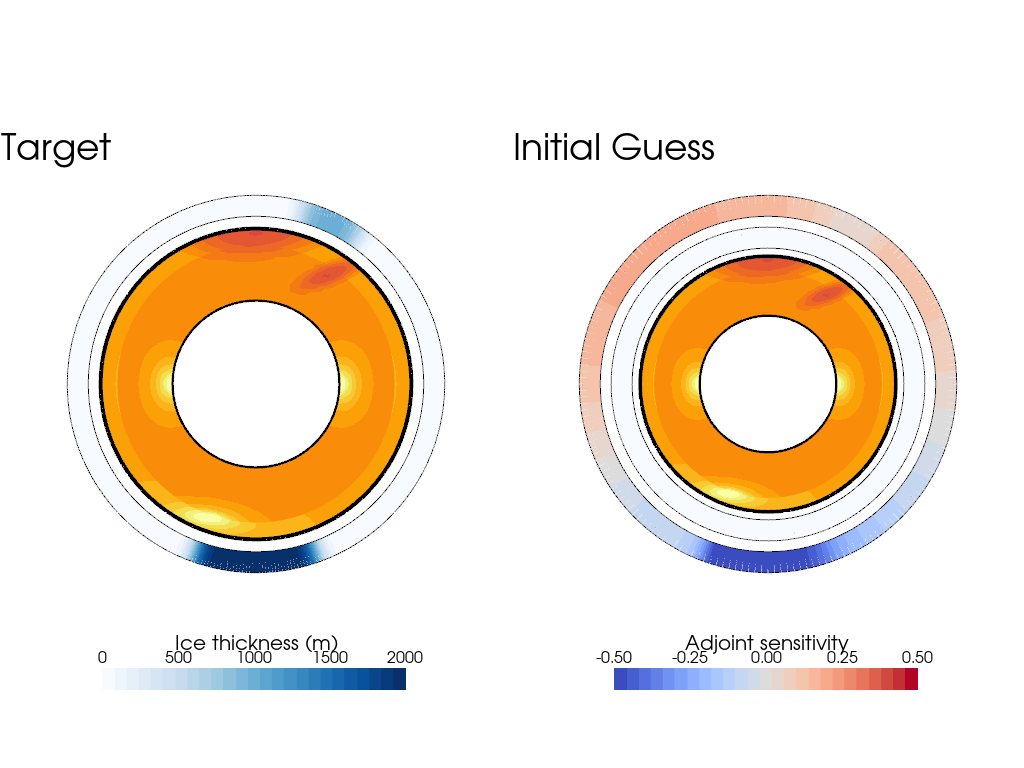

In [29]:
plotter = pv.Plotter(shape=(1, 2), border=False, notebook=True, off_screen=False)
plotter.subplot(0, 0)
plot_ice_ring(plotter, scalar='Ice thickness (target)', **plot_kwargs)
plot_viscosity(plotter, show_scalar_bar=False)
plotter.add_text("Target", position=text_pos)
plotter.camera_position = 'xy'
plotter.subplot(0, 1)
plot_ice_ring(plotter, scalar='Ice thickness (full mesh)')
plot_viscosity(plotter, show_scalar_bar=False)
plot_adj_ring(plotter, fname='adj_ice.pvd', stretch=1.4, **plot_kwargs)
plotter.camera_position = 'xy'
plotter.add_text("Initial Guess", position=text_pos)
plotter.show(jupyter_backend="static", interactive=False)
# Closes and finalizes movie
plotter.close()

### Verification of Gradients via a Taylor Test

A good way to verify the gradient is correct is to carry out a Taylor test. For
the control, $I_h$, reduced functional, $J(I_h)$, and its derivative,
$\frac{\mathrm{d} J}{\mathrm{d} I_h}$, the Taylor remainder convergence test can be
expressed as:

$$ \left| J(I_h + h \,\delta I_h) - J(I_h) - h\,\frac{\mathrm{d} J}{\mathrm{d} I_h} \cdot \delta I_h \right| \longrightarrow 0 \text{ at } O(h^2). $$

The expression on the left-hand side is termed the second-order Taylor remainder.
This term's convergence rate of $O(h^2)$ is a robust indicator for
verifying the computational implementation of the gradient calculation.
Essentially, if you halve the value of $h$, the magnitude
of the second-order Taylor remainder should decrease by a factor of 4.

We employ these so-called *Taylor tests* to confirm the accuracy of the
determined gradients. The theoretical convergence rate is
$O(2.0)$, and achieving this rate indicates that the gradient information
is accurate down to floating-point precision.

### Performing Taylor Tests

The test involves computing the functional and the associated gradient when randomly
perturbing the ice thickness field, $I_h$, and subsequently halving the perturbations
at each level.

Here is how you can perform a Taylor test in the code:

In [30]:
h = Function(ice_thickness_control)
h.dat.data[:] = np.random.random(h.dat.data_ro.shape)
minconv = taylor_test(reduced_functional, ice_thickness_control, h)

log("Expected rate: 2.0 (quadratic), Achieved:", minconv)

with open("taylor_test_minconv.txt", "w") as f:
    f.write(str(minconv))

displacement misfit 0.4449324513368951
velocity misfit 0.3014429475380092


Running Taylor test


displacement misfit 0.4449290708323992
velocity misfit 0.3011003781629555


displacement misfit 0.4449301642529931
velocity misfit 0.30127070300576764


displacement misfit 0.4449311585870304
velocity misfit 0.30135658531070975


displacement misfit 0.44493176765998443
velocity misfit 0.3013997064340648
Computed residuals: [6.216050959957523e-06, 1.5513491112818204e-06, 3.8650546335565266e-07, 9.59604586620231e-08]
Computed convergence rates: [2.002474948204845, 2.004962670704298, 2.0099768487581593]
Expected rate: 2.0 (quadratic), Achieved: 2.002474948204845


### Setting up the inversion

Now that we have verified our gradient is correct, let's start setting up an inversion.
First of all we will define some bounds that we enforce the control to lie within.
For this problem the lower bound of zero ice thickness is particularly important,
as we do not want negative ice thicknesses!

In [31]:
ice_thickness_lb = Function(ice_thickness_control.function_space(), name="ice thickness (lower bound)")
ice_thickness_ub = Function(ice_thickness_control.function_space(), name="Ice thickness (upper bound)")
ice_thickness_lb.assign(0.0)
ice_thickness_ub.assign(5)

bounds = [ice_thickness_lb, ice_thickness_ub]

Next we setup a pyadjoint minimization problem. We tweak G-ADOPT's default minimisation
parameters (found in `gadopt/inverse.py`) for our problem. We limit the number of
iterations to 5 just so that the demo is quick to run. (N.b. 20 iterations gives a
very accurate answer.)

In [32]:
minimisation_problem = MinimizationProblem(reduced_functional, bounds=bounds)

minimisation_parameters["Status Test"]["Iteration Limit"] = 5

optimiser = LinMoreOptimiser(
    minimisation_problem,
    minimisation_parameters,
    checkpoint_dir="optimisation_checkpoint",
)
# Restart file for optimisation...
updated_ice_thickness_file = VTKFile("updated_ice_thickness.pvd")
updated_out_file = VTKFile("updated_out.pvd")
functional_values = []

### Running the inversion

Now let's run the inversion!

In [33]:
optimiser.run()

displacement misfit 0.44493176765998443
velocity misfit 0.3013997064340648



Lin-More Trust-Region Method (Type B, Bound Constraints)
  iter  value          gnorm          snorm          delta          #fval     #grad     #hess     #proj     tr_flag   iterCG    flagCG    
  0     7.463315e-01   6.825769e-01   ---            1.000000e+00   1         1         0         2         ---       ---       ---       


displacement misfit 0.21614640063194496
velocity misfit 0.14783855055116296


  1     3.639850e-01   4.398759e-01   6.825769e-01   1.000000e+01   2         2         5         8         0         2         0         


displacement misfit 0.030859969285642254
velocity misfit 0.018865847946376486


  2     4.972582e-02   1.427495e-01   1.351016e+00   1.000000e+02   3         3         14        14        0         5         0         


displacement misfit 0.010557373523671601
velocity misfit 0.006132557386735337


  3     1.668993e-02   7.911398e-02   3.716349e-01   1.000000e+03   4         4         25        20        0         7         0         


displacement misfit 0.001339397909351593
velocity misfit 0.0007522586709825692


  4     2.091657e-03   2.007042e-02   3.769369e-01   1.000000e+04   5         5         38        26        0         9         0         


displacement misfit 0.0004528099162089432
velocity misfit 0.000273526113547318


  5     7.263360e-04   1.547315e-02   1.161564e-01   1.000000e+05   6         6         51        32        0         9         0         


Optimization Terminated with Status: Last Type (Dummy)


If we're performing multiple successive optimisations, we want
to ensure the annotations are switched back on for the next code
to use them

In [34]:
continue_annotation()

True

Let's plot the results of the inversion at the final iteration.

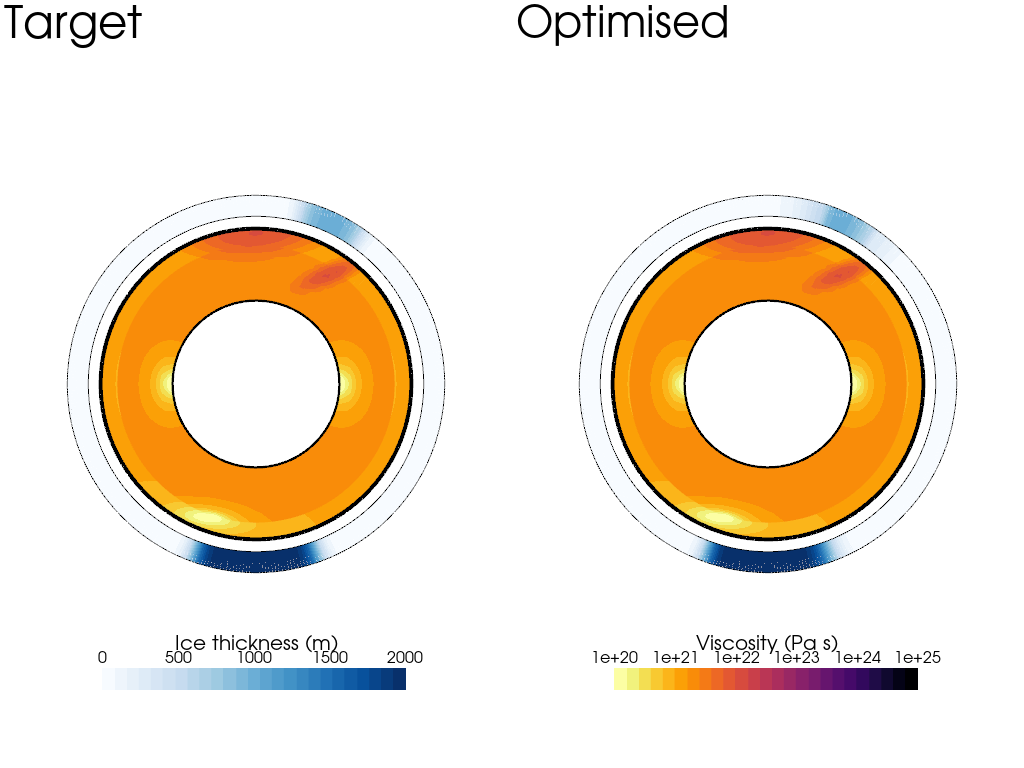

In [35]:
# Read the PVD file

# Create a plotter object
plotter = pv.Plotter(shape=(1, 2), border=False, notebook=True, off_screen=False)
plotter.subplot(0, 0)
plot_viscosity(plotter,show_scalar_bar=False)
plotter.add_text("Target")

plotter.subplot(0, 1)
plot_viscosity(plotter, **plot_kwargs)

plotter.subplot(0, 0)
plot_ice_ring(plotter, fname='ice.pvd', scalar='Ice thickness (target)', **plot_kwargs)
plotter.camera_position = 'xy'
plotter.subplot(0, 1)
plot_ice_ring(plotter, fname='updated_ice_thickness.pvd', scalar='Ice thickness (updated)', timestep=5, thickness_scale=1000, **plot_kwargs)

plotter.camera_position = 'xy'
plotter.add_text("Optimised")
plotter.show(jupyter_backend="static", interactive=False)
plotter.close()

We can see that we have been able to recover two ice sheets in the correct locations!

And we'll write the functional values to a file so that we can test them.

In [36]:
with open("functional.txt", "w") as f:
    f.write("\n".join(str(x) for x in functional_values))

We can confirm that the surface misfit has reduced by plotting
the objective function at each iteration.

Text(0.5, 1.0, 'Convergence')

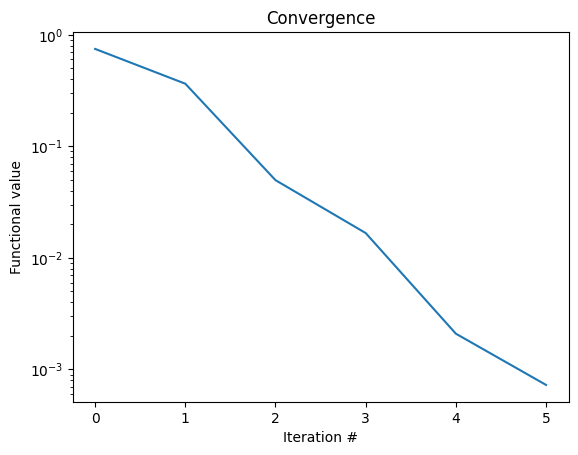

In [37]:
plt.semilogy(functional_values)
plt.xlabel("Iteration #")
plt.ylabel("Functional value")
plt.title("Convergence")